In [115]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


<Figure size 1440x432 with 0 Axes>

In [116]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from scipy.stats import gamma, norm, beta, uniform
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver


from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import set_up_kalman_filter, kalman_filter, sample_from_priors, solve_updated_mod, get_arr_pdf_from_dist
from src.utils import printProgBar, get_most_recent_mod_output

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [117]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'Y', 'pi_c', 'w'], axis=1).rename(columns={'Y_p': 'Y', 'pi_s': 'pi'})

# split train and test
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [118]:
mods = {
    'mod4_rbc_vanilla': {},
    'mod5_nk_vanilla': {}
}

for item in mods.keys():
    mods[item]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{item}.gcn'), verbose=False)
    
for item in mods.keys():
    _, mods[item]['mod'] = solve_updated_mod(mods[item]['mod'], verbose=False)
    assert _ == True

In [119]:
for key in mods.keys():
    file_name = get_most_recent_mod_output(POST_EST_DIR, key)
    print(file_name)
    mods[key]['post_out'] = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

mod4_rbc_vanilla_2023-03-26_15_3.nc
mod5_nk_vanilla_2023-03-26_16_2.nc


load posterior estimation data

In [120]:
name = 'mod5_nk_vanilla'
xarr = mods[name]['post_out']
mod = mods[name]['mod']

In [121]:
from scipy.stats import gamma, beta, norm
prior_dist = {
    'alpha': beta(2, 5),
     'eta_p': beta(10, 3.4),
     'gamma_Y': gamma(4, 0, .5),
     'gamma_pi': gamma(4, 0, .5),
     # 'rho_A': beta(.95, 0.04),
     'epsilon_A': beta(1.2, 1.2),
     'epsilon_R': beta(1.2, 1.2),
     'sigma_C': norm(2, 2),
     'sigma_L': norm(2, 2),
     'epsilon_T': beta(1.2, 1.2),
    'epsilon_Y': beta(1.2, 1.2),
    'epsilon_pi': beta(1.2, 1.2),
}

In [122]:
from src.utils import all_equal, get_confidence_interval
def plot_dfs(dfs_data: list, plotfunc, cols: int = 3, figsize: tuple = (14, 4), fill_arr=None,
             legend: list = None, recs_lable='Recessions', dfs_cov: list=None, conf_sigma: float=1.96, **kwargs):
    # if single data frame put into list
    if type(dfs_data) != list: dfs_data = [dfs_data]
    if (type(dfs_cov) != list) & (dfs_cov is not None): dfs_cov = [dfs_cov]

    # check legend sanity
    if legend is not None: assert len(legend) == len(dfs_data), "No sufficient legend titles supplied"

    # check df sanity
    if dfs_cov is not None:
        for mu, cov in [[x, y] for x in dfs_data for y in dfs_cov]:
            if cov is not None:
                _ = [item for item in mu.columns if item not in cov.columns]
                assert len(_) == 0, f"{_} not contained in dfs_cov"
                assert type(mu) == type(cov) == pd.core.frame.DataFrame, "dfs list item is not a pandas data frame"
            else:
                for df in dfs_data:
                    assert type(df) == pd.core.frame.DataFrame, "dfs list item is not a pandas data frame"
    else:
        for df in dfs_data:
            assert type(df) == pd.core.frame.DataFrame, "dfs list item is not a pandas data frame"

    assert all_equal([list(item.columns) for item in dfs_data]) == True, "df columns have to be the same"

    # set rows based on max dimensions
    rows = int(np.ceil(max([item.shape[1] for item in dfs_data]) / cols))
    start = min([item.index.min() for item in dfs_data])
    end = max([item.index.max() for item in dfs_data])

    # initatiate figure
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize[0], figsize[1] * rows))

    for id, df in enumerate(dfs_data):
        if dfs_cov is not None:
            cov = dfs_cov[id]
        else:
            cov = None

        for i, col in enumerate(df.columns):
            _axr = int(np.floor(i / cols))
            _axc = int(round((i / cols - np.floor(i / cols)) * cols))

            # excluding axcol value, in case of one dimensional axis
            if len(ax.shape) == 1:
                _ax = ax[_axc]
            else:
                _ax = ax[_axr, _axc]

            # plot confidence intervals
            if cov is not None:
                upper, lower = get_confidence_interval(df[col], cov[col], sigma=conf_sigma)
                _ax.fill_between(df[col].index, upper, lower, color='b', alpha=.1, label=f'{conf_sigma} conf int')

            # plot graph
            if legend is not None:
                plotfunc(df[col], ax=_ax, label=legend[id], **kwargs)
            else:
                plotfunc(df[col], ax=_ax, **kwargs)
            _ax.set_title(col)

            if fill_arr is not None and id == len(dfs_data) - 1:
                # only inlcude relevant recessions
                for t in fill_arr:
                    if t[1] < start:
                        continue
                    if t[0] < start:
                        t[0] = start
                    if t[0] > end:
                        continue
                    if t[1] > end:
                        t[1] = end
                    # plot recessions
                    _ax.axvspan(t[0], t[1], alpha=.1, color='red')

    # if legend is not None: plt.legend()
    fig.tight_layout()
    plt.show()
    pass


In [123]:
n_runs = xarr.n_runs.values
x1 = pd.DataFrame(xarr.posterior[int(n_runs/2):], columns=xarr.parameter)
x2 = pd.DataFrame([[prior_dist[param].rvs() for item in range(0, int(n_runs/2))] for param in xarr.parameter.values],
                  index=xarr.parameter).transpose()
plot_dfs(dfs_data=[x1, x2], plotfunc=sns.histplot, alpha=.5, legend=['posterior', 'prior'])

KeyError: 'gamma_R'

### filterpy

In [97]:
mod_params = mod.free_param_dict.copy()

if not 'pi' in [item.base_name for item in mod.variables]:
    if 'pi' in train.columns: train.drop('pi', axis=1, inplace=True)

In [102]:
# update mod params with posterior mean
mod_params.update({param: float(xarr.sel(parameter=param).posterior[int(n_runs/2):].mean().values) for param in xarr.parameter.values})

In [103]:
shock_names = [x.base_name for x in mod.shocks]
state_variables = [x.base_name for x in mod.variables]
observed_vars = ["Y"]

params, shocks = sample_from_priors(prior_dist, mod_params, shock_names)
mod.free_param_dict.update(params)
solved, mod = solve_updated_mod(mod, verbose=False)
if not solved: raise ValueError


T, R = mod.T.values, mod.R.values
H, Z, T, R, QN, zs = set_up_kalman_filter(R=R, T=T, observed_data=train[observed_vars].values, observed_vars=observed_vars, 
                                          shock_names=shock_names, shocks_drawn_prior=shocks, state_variables=state_variables)

kfilter = KalmanFilter(len(state_variables), len(observed_vars))
kfilter.F = mod.T
kfilter.Q = QN
kfilter.H = Z
kfilter.R = H

In [104]:
saver = Saver(kfilter)
mu, cov, _, _ = kfilter.batch_filter(zs, saver=saver)
ll = saver.log_likelihood
print(np.sum(ll))
mu_df = pd.DataFrame(mu.reshape(len(mu), -1),
                     columns=[item.base_name for item in mod.variables],
                     index=train.index)
cov_df = pd.DataFrame(cov.diagonal(axis1=1, axis2=2), columns=[item.base_name for item in mod.variables], index=train.index)

-92.76468734416231


In [105]:
# ind = 4
# x = mu[:, ind, 0]
# confidence_lower =  1.96 * cov[:, ind, ind]
# confidence_upper = 1.96 * cov[:, ind, ind]
# plt.plot(x)
# plt.fill_between(range(0, len(x)), (x-confidence_lower), (x+confidence_upper), color='b', alpha=.1)
# plt.plot(train['L'].iloc[20:].values)

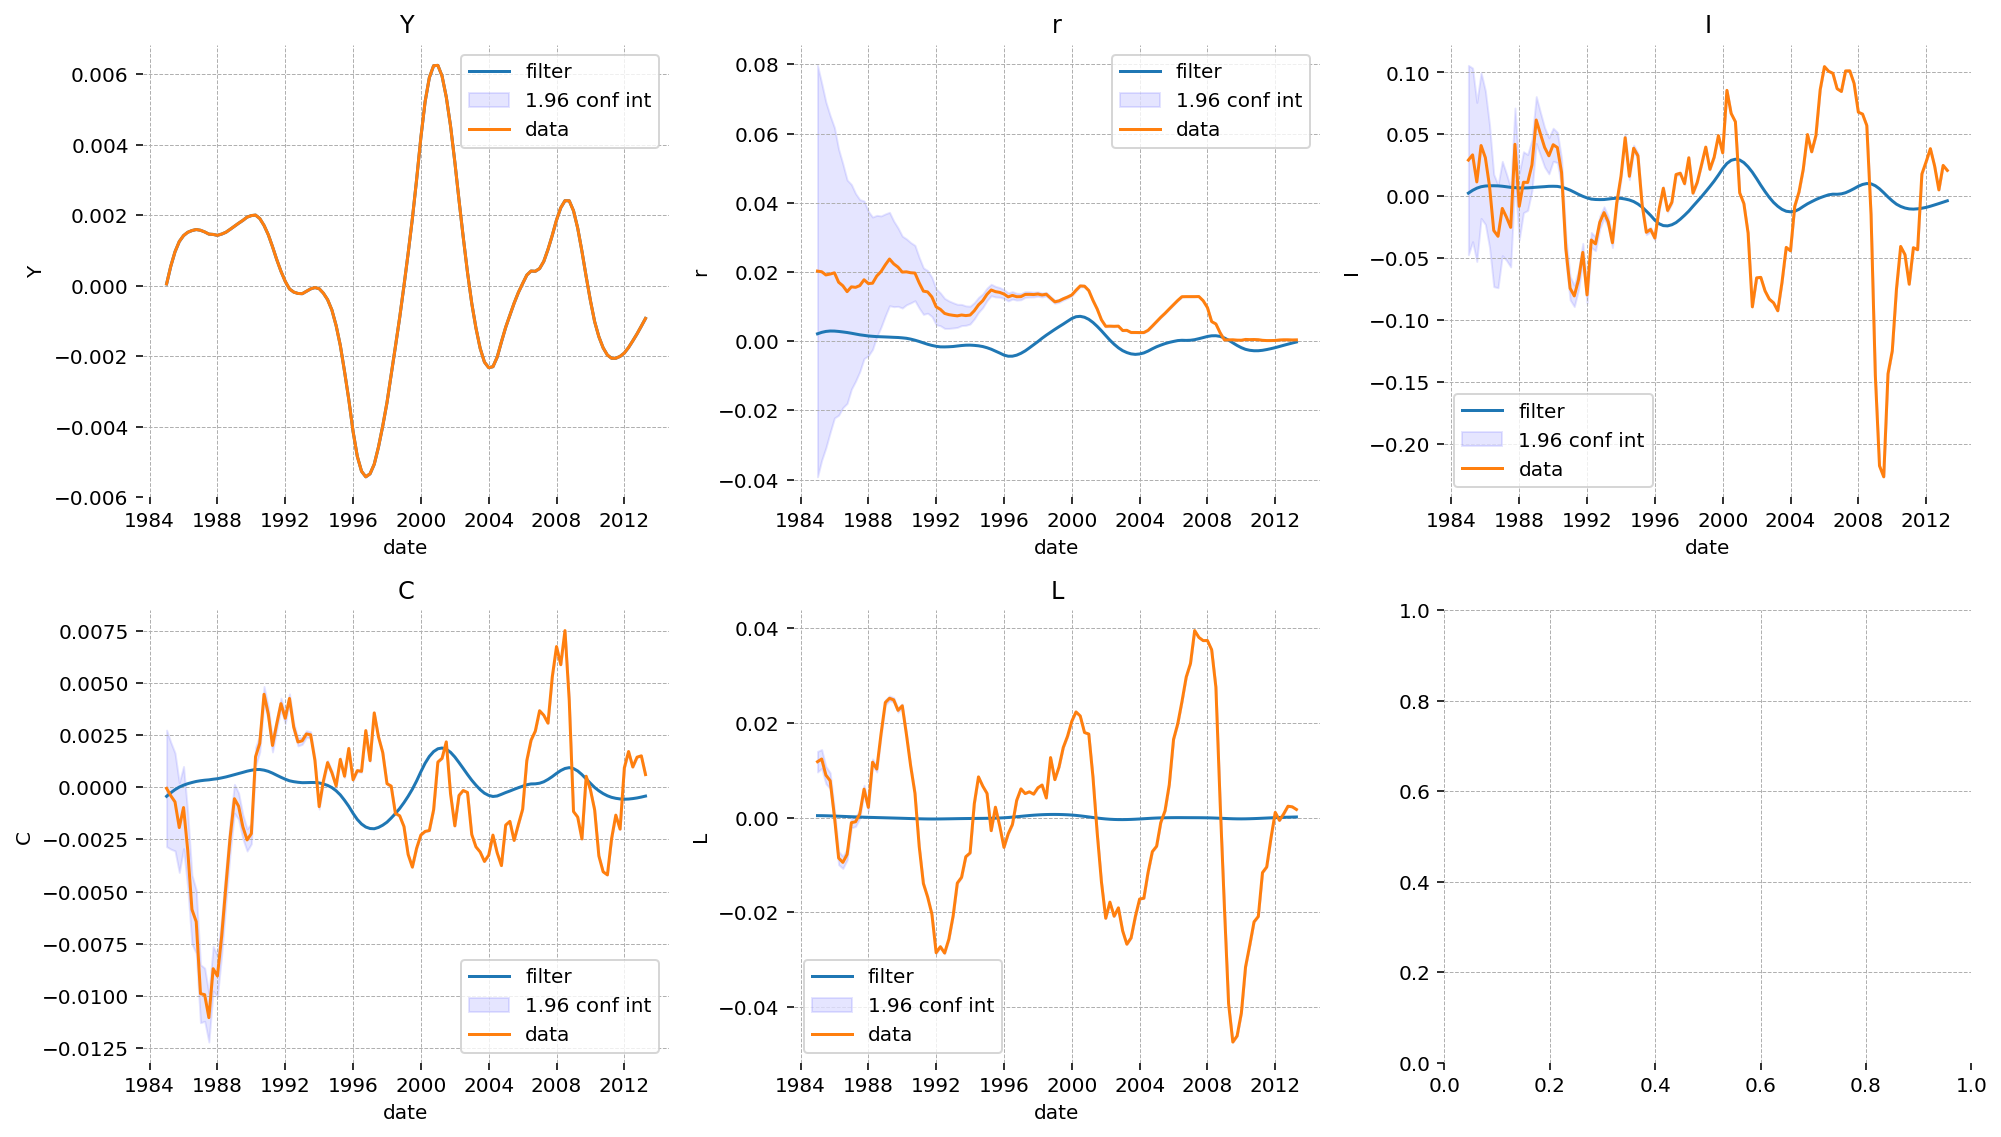

In [110]:
ind = 40
plot_dfs([mu_df[train.columns].iloc[ind:], train.iloc[ind:]], plotfunc=sns.lineplot, dfs_cov=[None, cov_df.iloc[ind:]], legend=['filter', 'data'])